# CNN using Pytorch on the astar dataset
Goal is to use CNNs to solve the supervised learning problem for finding the correct class label for the astar dataset

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [9]:
# First let's load the dataset
from datasets.astar_dataset import make_astar_dataset
import time


# Set the grid size here
n, m = 5, 5  # grid size for the problem
N = 100000     # Number of examples

# Probability of existence of obstacle
obstacle_probability = 0.3


# Create the data set
start = time.time()
X, y = make_astar_dataset(N, n, m, obstacle_probability)
print(f"Execution time: {time.time() - start:.4f} seconds")

Execution time: 7.5205 seconds


In [10]:
import pandas as pd

# Print the statistics of each class label
y_df = pd.DataFrame(y)  # Convert y to a pandas Series if it's not already
y_df.describe()

,0,1,2,3,4
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.188800,0.188800,0.188800,0.188800,0.244800
std,0.391352,0.391352,0.391352,0.391352,0.429971
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
# Convert the labels from one_hot vector to integer indicies
import numpy as np
y = np.argmax(y, axis=1) 

In [12]:
# Create a custom torch dataset
import torch
from torch.utils.data import Dataset, DataLoader

X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).long()

# Create a custom dataset class to retrieve the data
class BinaryImageDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]


# Create the dataset and dataloader classes

dataset = BinaryImageDataset(X_tensor, y_tensor)
trainloader = DataLoader(dataset, batch_size=4, shuffle=True)

torch.Size([3, 5, 5])
right


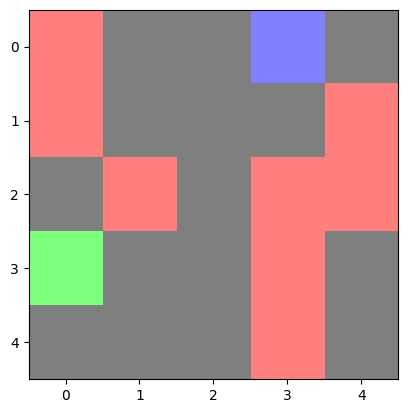

In [13]:
# Visualize some of the images
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Visualizing the dataset

classes = ("up", "left", "down", "right", "no_path")

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(trainloader)
images, labels = next(dataiter)

img = images[0]
label = labels[0].item()

print(img.shape)
# imshow(torchvision.utils.make_grid(images))
imshow(img)

print(classes[label])


In [16]:
# Let's now create a network that can solve this problem
import torch.nn as nn
import torch.nn.functional as F

class AstarNetwork(nn.Module):
    def __init__(self):
        super(AstarNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 2)
        self.fc1 = nn.Linear(16 * 3 * 3, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 16 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = AstarNetwork()
net(img)

tensor([[-0.0168,  0.0272, -0.0851,  0.0229,  0.0068,  0.0022,  0.0250, -0.0115,
          0.0126, -0.0576]], grad_fn=<AddmmBackward0>)

In [24]:
import torch.optim as optim
# Define the loss and the optimizer
criterion = nn.CrossEntropyLoss() # The cross entropy loss for classification
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Train
for epoch in range(2): # Loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        # Zero gradient here is an important step
        # Gradients are accumulated over a batch, if we don't reset the gradient here we will keep accumulating gradients
        # making it impossible to train
        optimizer.zero_grad() 

        # Forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward() # Compute the gradients that will direct the learning
        optimizer.step() # actually learn (one learning step)

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999: # print every 2000 minibatches
            print(f"[{epoch}, {i}] loss: {running_loss / 2000}")
            running_loss = 0.0

[0, 1999] loss: 0.20638796938219456
[0, 3999] loss: 0.21065316307238527
[0, 5999] loss: 0.20536157446226344
[0, 7999] loss: 0.1989105144061473
[0, 9999] loss: 0.19997391448260896
[0, 11999] loss: 0.20906755476985744
[0, 13999] loss: 0.20421540875558458
[0, 15999] loss: 0.19820770329271956
[0, 17999] loss: 0.2021563725722499
[0, 19999] loss: 0.20677202260808417
[0, 21999] loss: 0.20354850085637008
[0, 23999] loss: 0.2031575512522568
[1, 1999] loss: 0.20093943335754347
[1, 3999] loss: 0.1991322250328974
[1, 5999] loss: 0.19496676701679097
[1, 7999] loss: 0.19449014881538415
[1, 9999] loss: 0.20521756145048403
[1, 11999] loss: 0.19739141212355207
[1, 13999] loss: 0.2110900973192288
[1, 15999] loss: 0.19913203360342596
[1, 17999] loss: 0.20321195960312344
[1, 19999] loss: 0.21026030896202247
[1, 21999] loss: 0.19355191665762322
[1, 23999] loss: 0.1962064299900194


In [25]:
# Training accuracy
correct = 0
total = 0
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Training accuracy: {100 * correct / total}')

Accuracy of the network on the 10000 test images: 90.1


In [29]:
# Generate a test set and test on it
# Create the data set

N_test = 100000

start = time.time()
X_test, y_test = make_astar_dataset(N_test, n, m, obstacle_probability)
print(f"Execution time: {time.time() - start:.4f} seconds")

y_test = np.argmax(y_test, axis=1)


X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).long()

test_dataset = BinaryImageDataset(X_test, y_test)
testloader = DataLoader(test_dataset, batch_size=4, shuffle=True)

Execution time: 7.5404 seconds


In [30]:
# Testing accuracy

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Testing accuracy: {100 * correct / total}')

Testing accuracy: 86.173


# TODO

- Test with different model architectures
- Explore imitation learning techniques
- Explore RL techniques
Good article summarizing the different approaches that exist https://smartlabai.medium.com/a-brief-overview-of-imitation-learning-8a8a75c44a9c
- Test with imitation learning https://imitation.readthedocs.io/en/latest/index.html